<hr style="margin-bottom: 50px;">
<center>
    <h1 style="margin-top: 0; margin-bottom: 0;">
        <b><u>Modélisation : Elastic-SARIMAX</u></b>
    </h1>
</center>
<hr style="margin-top: 50px;">

# <b>1. Configuration du notebook

In [17]:
# Imports des modules du projet
import config, src

# Imports classiques
import numpy as np
import pandas as pd

# Imports de scikit-learn
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error

# Imports de statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import aic

# Imports pour la visualisation
import plotly.graph_objects as go

---
# <b>2. Chargement et préparation des données</b>

In [18]:
# Chargement des données prétraitées
data = src.load_data(config.PROCESSED_DATA_FILE)

# Conversion des données au format datetime
data['Date'] = pd.to_datetime(data['Date'])

# Utilisation des dates comme index
data.set_index('Date', inplace=True)

# Ajout de la fréquence des données
data = data.asfreq('10min')

Données chargées avec succès.


In [19]:
# Ajout d'un intercept
data['intercept'] = 1

# Variables explicatives
features = data.columns.drop('Energy')

# Données explicatives
X = data[features]

# Données cibles
y = data['Energy']

---
# <b>3. Définition du modèle</b>

In [20]:
def train_elastic_net(X, y, alpha=0.1, l1_ratio=0.5):
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X, y)

    return model

def apply_sarimax(residuals, order=(1, 0, 1), seasonal_order=(1, 0, 1, 14)):
    model = SARIMAX(residuals, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit(disp=0)
    
    return fitted_model

In [21]:
def sliding_window_forecast(X, y, window_size, step_size, verbose=True):
    predictions = []
    true_values = []

    n_iter = 0 
    for start in range(0, len(X) - window_size, step_size):
        n_iter += 1
        
        end = start + window_size

        if verbose:
            train_period = data.index[start:end]
            test_period = data.index[end:end + step_size]
            print(f'{n_iter} | Apprentissage des données de {train_period[0]} à {train_period[-1]} | Prévision de {test_period[0]} à {test_period[-1]}')

        X_train, y_train = X.iloc[start:end], y.iloc[start:end]
        X_test, y_test = X.iloc[end:end + step_size], y.iloc[end:end + step_size]
        
        model = train_elastic_net(X_train, y_train)
        
        residuals = y_train - model.predict(X_train)

        sarimax_model = apply_sarimax(residuals)
        future_residuals = sarimax_model.forecast(steps=len(X_test))
        
        future_prediction = np.maximum(model.predict(X_test) + future_residuals, 0)

        predictions.extend(future_prediction)
        true_values.extend(y_test)
    
    mse = mean_squared_error(true_values, predictions)
    rmse = root_mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    aic_value = aic(np.array(true_values), np.array(predictions), len(X.columns))
    
    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}, AIC: {aic_value}')
    
    return predictions

---
# <b>4. Entraînement et évaluation du modèle</b>

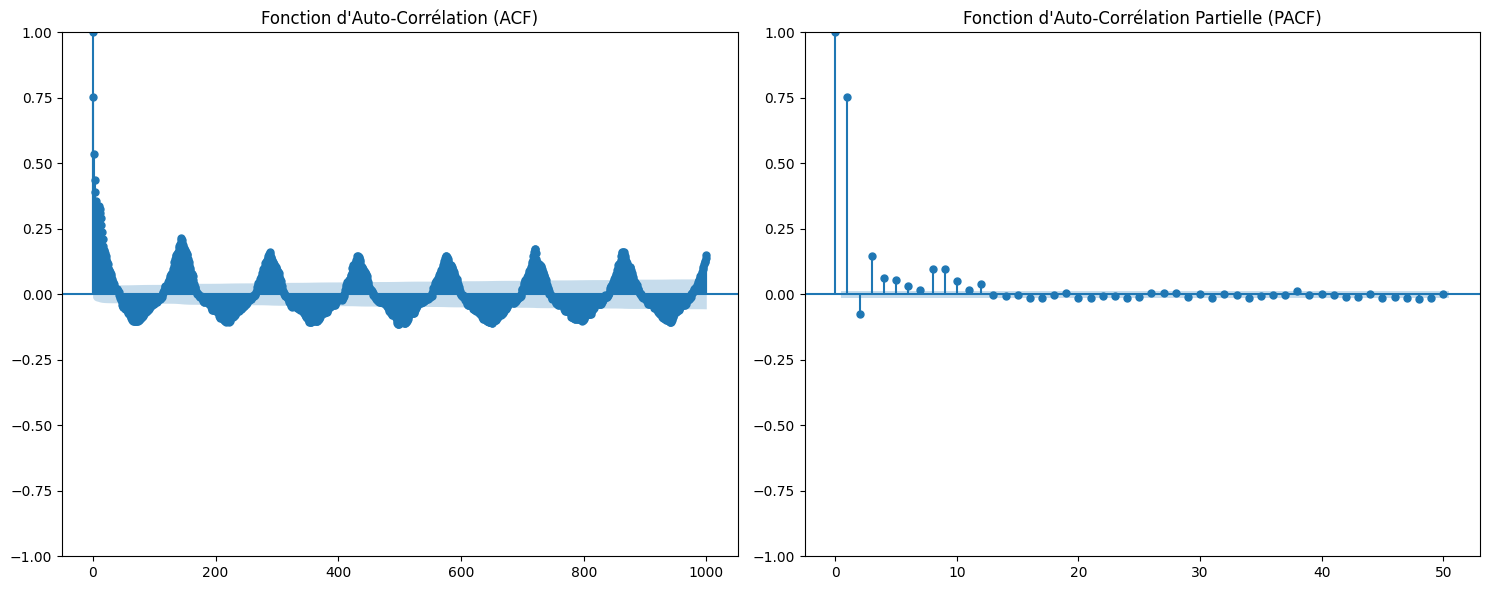

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Générer les graphiques ACF et PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(y, lags=1000, ax=axes[0])  # Graphique ACF
axes[0].set_title("Fonction d'Auto-Corrélation (ACF)")
plot_pacf(y, lags=50, ax=axes[1])  # Graphique PACF
axes[1].set_title("Fonction d'Auto-Corrélation Partielle (PACF)")
plt.tight_layout()
plt.show()

In [23]:
# Taille de la fenêtre d'apprentissage (2 mois)
window_size = (data.index <= "2016-03-11 17:00:00").sum()

In [24]:
predictions = sliding_window_forecast(X, y, window_size=window_size, step_size=144)

1 | Apprentissage des données de 2016-01-11 17:00:00 à 2016-03-11 17:00:00 | Prévision de 2016-03-11 17:10:00 à 2016-03-12 17:00:00
2 | Apprentissage des données de 2016-01-12 17:00:00 à 2016-03-12 17:00:00 | Prévision de 2016-03-12 17:10:00 à 2016-03-13 17:00:00
3 | Apprentissage des données de 2016-01-13 17:00:00 à 2016-03-13 17:00:00 | Prévision de 2016-03-13 17:10:00 à 2016-03-14 17:00:00
4 | Apprentissage des données de 2016-01-14 17:00:00 à 2016-03-14 17:00:00 | Prévision de 2016-03-14 17:10:00 à 2016-03-15 17:00:00
5 | Apprentissage des données de 2016-01-15 17:00:00 à 2016-03-15 17:00:00 | Prévision de 2016-03-15 17:10:00 à 2016-03-16 17:00:00
6 | Apprentissage des données de 2016-01-16 17:00:00 à 2016-03-16 17:00:00 | Prévision de 2016-03-16 17:10:00 à 2016-03-17 17:00:00
7 | Apprentissage des données de 2016-01-17 17:00:00 à 2016-03-17 17:00:00 | Prévision de 2016-03-17 17:10:00 à 2016-03-18 17:00:00
8 | Apprentissage des données de 2016-01-18 17:00:00 à 2016-03-18 17:00:00 |

In [25]:
model_results = pd.DataFrame({'y_pred': predictions, 'y_true': y.iloc[window_size:].values}).set_index(data.index[window_size:])
model_results

,y_pred,y_true
Date,,
2016-03-11 17:10:00,65.286197,40
2016-03-11 17:20:00,82.877367,40
2016-03-11 17:30:00,91.630655,60
2016-03-11 17:40:00,94.921489,60
2016-03-11 17:50:00,94.791177,70
...,...,...
2016-05-27 17:20:00,162.117513,100
2016-05-27 17:30:00,173.711078,90
2016-05-27 17:40:00,181.075412,270


In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=model_results.index, y=model_results['y_true'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=model_results.index, y=model_results['y_pred'], mode='lines', name='Predicted'))

fig.update_layout(title='Model Predictions', xaxis_title='Time', yaxis_title='Value')

fig.show()

---